# Attention for classification

In [40]:
from __future__ import unicode_literals, print_function, division
from io import open
import unicodedata
import string
import re
import random
import numpy as np

import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
%matplotlib inline

## Loading data files


In [41]:
def unpack_dataset():
    ! wget http://www.cs.cornell.edu/people/pabo/movie-review-data/rotten_imdb.tar.gz
    ! mkdir data
    ! tar -xvf rotten_imdb.tar.gz -C data

In [3]:
#unpack_dataset()

In [4]:
from pathlib import Path
PATH = Path("data")
list(PATH.iterdir())

[PosixPath('data/plot.tok.gt9.5000'),
 PosixPath('data/subjdata.README.1.0'),
 PosixPath('data/quote.tok.gt9.5000')]

## Tokenization

In [5]:
# We need each line in the file 
def read_file(path):
    """ Read file returns a list of lines.
    """
    with open(path, encoding = "ISO-8859-1") as f:
        content = f.readlines()
    return content

In [6]:
sub_content = read_file(PATH/"quote.tok.gt9.5000")
obj_content = read_file(PATH/"plot.tok.gt9.5000")
sub_content = np.array([line.strip().lower() for line in sub_content])
obj_content = np.array([line.strip().lower() for line in obj_content])
sub_y = np.zeros(len(sub_content))
obj_y = np.ones(len(obj_content))
X = np.append(sub_content, obj_content)
y = np.append(sub_y, obj_y)

## Split dataset in train and validation

In [7]:
from sklearn.model_selection import train_test_split

In [8]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

## Word to index mapping

In [9]:
from collections import defaultdict

def get_vocab(content):
    """Computes Dict of counts of words.
    
    Computes the number of times a word is on a document.
    """
    vocab = defaultdict(float)
    for line in content:
        words = set(line.split())
        for word in words:
            vocab[word] += 1
    return vocab

In [10]:
#Getting the vocabulary from the training set
word_count = get_vocab(X_train)
len(word_count.keys())

21415

In [11]:
for word in list(word_count):
    if word_count[word] < 5:
        del word_count[word]

In [12]:
len(word_count.keys())

4065

In [13]:
## Finally we need an index for each word in the vocab
vocab2index = {"<PAD>":0, "UNK":1} # init with padding and unknown
words = ["<PAD>", "UNK"]
for word in word_count:
    vocab2index[word] = len(words)
    words.append(word)

In [14]:
voc_size = len(words)

## Sentence encoder

In [15]:
def encode_sentence(s, N=40):
    enc = np.zeros(N, dtype=np.int32)
    enc1 = np.array([vocab2index.get(w, vocab2index["UNK"]) for w in s.split()])
    l = min(N, len(enc1))
    enc[:l] = enc1[:l]
    return enc

In [16]:
x_train = np.vstack([encode_sentence(x) for x in X_train])
x_train.shape

(8000, 40)

In [17]:
x_val = np.vstack([encode_sentence(x) for x in X_val])
x_val.shape

(2000, 40)

In [18]:
class SentenceDataset(Dataset):
    def __init__(self, x, y):
        
        self.x = x
        self.y = y
        
    def __len__(self):
        return len(self.y)
    
    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]

In [19]:
train_ds = SentenceDataset(x_train, y_train)
valid_ds = SentenceDataset(x_val, y_val)

In [20]:
batch_size = 5
train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
val_dl = DataLoader(valid_ds, batch_size=batch_size)

The Encoder Model
-----------
The attention works like this [paper](https://www.cs.cmu.edu/~hovy/papers/16HLT-hierarchical-attention-networks.pdf). Let $w_t$ represents the words on a sentence $t \in \{1 \dots T \}$. $x_t$ the word embedding for $t$ and $h_t$ the output of the GRU for word $t$.

$$u_t =  tanh(W_w h_t + b_w)$$
$$\alpha_t = \frac{exp(u_t^T v_w)}{\sum_t exp(u_t^T v_w)}$$
$$s = \sum_t \alpha_t h_t$$


The context vector $v_w$ can be seen as a high level representation of a fixed
query "what is the informative word" over the words like that used in memory networks (Sukhbaatar et al., 2015; Kumar et al., 2015). The word context vector $v_w$ is randomly initialized and jointly learned during the training process.

In [21]:
class EncoderDecRNN(nn.Module):
    def __init__(self, voc_size, emb_size=50, hidden_size=60):
        super(EncoderDecRNN, self).__init__()

        self.embedding = nn.Embedding(voc_size, emb_size, padding_idx=0)
        self.gru = nn.GRU(emb_size, hidden_size, batch_first=True)
        self.attn1 = nn.Linear(hidden_size, hidden_size)
        self.attn2 = nn.Linear(hidden_size, 1, bias=False)
        self.linear = nn.Linear(hidden_size, 1)
        
    def forward(self, x):
        x = self.embedding(x)
        output, hidden = self.gru(x)
        u = self.attn1(output)
        alpha = F.softmax(self.attn2(u), dim=1)
        s = (alpha*output).sum(1)
        h_star = self.linear(s)
        return h_star, alpha

In [22]:
emb_size=50; hidden_size=20
embedding = nn.Embedding(voc_size, emb_size, padding_idx=0)
gru = nn.GRU(emb_size, hidden_size, batch_first=True)
attn1 = nn.Linear(hidden_size, hidden_size)
attn2 = nn.Linear(hidden_size, 1, bias=False)

In [23]:
x, y = next(iter(train_dl))

In [24]:
emb = embedding(x.long())
output, hidden = gru(emb)
u = attn1(output)
alpha = F.softmax(attn2(u), dim=1)

alpha.shape

torch.Size([5, 40, 1])

In [25]:
[p.shape for p in attn1.parameters()]

[torch.Size([20, 20]), torch.Size([20])]

In [26]:
model = EncoderDecRNN(voc_size)

In [27]:
x, y = next(iter(train_dl))

In [28]:
y_hat = model(x.long())

In [29]:
def val_metrics(model):
    model.eval()
    x = torch.LongTensor(x_val) #.cuda()
    y = torch.Tensor(y_val).unsqueeze(1) #).cuda()
    y_hat, _ = model(x)
    loss = F.binary_cross_entropy_with_logits(y_hat, y)
    y_pred = y_hat > 0
    correct = (y_pred.float() == y).float().sum()
    accuracy = correct/y_pred.shape[0]
    return loss.item(), accuracy.item()

In [30]:
val_metrics(model)

(0.6926704049110413, 0.5024999976158142)

In [31]:
batch_size = 3000
train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
val_dl = DataLoader(valid_ds, batch_size=batch_size)

Training
========

In [32]:
def train_epocs(model, train_dl, epochs=10, lr=0.001):
    parameters = filter(lambda p: p.requires_grad, model.parameters())
    optimizer = torch.optim.Adam(parameters, lr=lr)
    for i in range(epochs):
        model.train()
        sum_loss = 0.0
        total = 0
        for x, y in train_dl:
            x = x.long()
            y = y.float()
            y_pred, _ = model(x)
            optimizer.zero_grad()
            loss = F.binary_cross_entropy_with_logits(y_pred, y.unsqueeze(1))
            loss.backward()
            optimizer.step()
            sum_loss += loss.item()*y.shape[0]
            total += y.shape[0]
        val_loss, val_acc = val_metrics(model)
        print("train loss %.3f val loss %.3f val acc %.3f"% (sum_loss/total, val_loss, val_acc))
        

In [33]:
model = EncoderDecRNN(voc_size)

In [34]:
train_epocs(model, train_dl, epochs=10, lr=0.01)

train loss 0.688 val loss 0.661 val acc 0.673
train loss 0.632 val loss 0.535 val acc 0.746
train loss 0.513 val loss 0.501 val acc 0.763
train loss 0.449 val loss 0.437 val acc 0.805
train loss 0.385 val loss 0.378 val acc 0.835
train loss 0.325 val loss 0.351 val acc 0.845
train loss 0.278 val loss 0.334 val acc 0.863
train loss 0.238 val loss 0.317 val acc 0.871
train loss 0.199 val loss 0.321 val acc 0.876
train loss 0.170 val loss 0.301 val acc 0.885


In [35]:
train_epocs(model, train_dl, epochs=10, lr=0.001)

train loss 0.147 val loss 0.316 val acc 0.882
train loss 0.140 val loss 0.313 val acc 0.883
train loss 0.136 val loss 0.319 val acc 0.885
train loss 0.131 val loss 0.319 val acc 0.885
train loss 0.128 val loss 0.318 val acc 0.884
train loss 0.124 val loss 0.320 val acc 0.885
train loss 0.120 val loss 0.328 val acc 0.885
train loss 0.116 val loss 0.333 val acc 0.885
train loss 0.112 val loss 0.335 val acc 0.886
train loss 0.108 val loss 0.337 val acc 0.887


Evaluation
==========

In [36]:
def evaluate(model, sents):
    model.eval()
    x = np.vstack([encode_sentence(x) for x in sents])
    x = torch.LongTensor(x)
    h_star, alpha = model(x)    
    return alpha

In [37]:
K = 300
sents = X_train[K:K+10]
y = y_train[K:K+10]
n = [len(x.split(" ")) for x in sents]
alpha= evaluate(model, X_train[K:K+10])

In [49]:
k = 3
sents[k], y[k], n[k]

("the movie occasionally threatens to become didactic , but it's too grounded in the reality of its characters to go over the edge . a touch of humor or an unexpected plot twist always pulls it back .",
 0.0,
 38)

In [52]:
k = 4
sents[k], y[k], n[k]

('during his skyrocketing career , johnathan has to experience what alexi has found out : blood brings more viewing pleasure to the audience .',
 1.0,
 24)

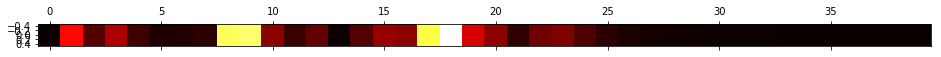

In [53]:
import matplotlib.pyplot as plt
plt.matshow(alpha[k].detach().numpy().transpose(), cmap='hot')

In [48]:
alpha[k].detach().numpy().transpose()

array([[0.01005536, 0.02461828, 0.09699872, 0.01900655, 0.00360862,
        0.06046836, 0.02709289, 0.05378465, 0.03126656, 0.0727753 ,
        0.01021754, 0.00594439, 0.00589792, 0.00724281, 0.00916246,
        0.01123917, 0.01324425, 0.01507461, 0.01669827, 0.01811671,
        0.01934527, 0.02040414, 0.02131431, 0.02209583, 0.02276696,
        0.02334391, 0.02384075, 0.02426954, 0.02464052, 0.02496237,
        0.02524234, 0.02548659, 0.02570024, 0.02588763, 0.02605241,
        0.02619767, 0.02632601, 0.02643963, 0.02654045, 0.02663008]],
      dtype=float32)